# <center>Machine Learning Project</center>

** **
## <center>*02 - Feature Selection*</center>

** **

The members of the `team` are:
- Ana Farinha - 20211514
- Francisco Capontes - 20211692
- Sofia Gomes - 20240848
- Rui Lourenço - 2021639

## <span style="color:salmon"> Table of Contents </span>

<a class="anchor" id="top"></a>


1. [Filter Methods](#1-filter-methods)<br>  
    1.1 [Univariate Variables](#11-univariate-variables)<br>  
    1.2 [Correlation Indices](#12-correlation-indices)<br>    
    1.3 [Chi-Squared](#13-chi-squared)<br><br>     
2. [Wrapper Methods](#2-wrapper-methods)<br>    
    2.1 [Logistic Regression](#21-logistic-regression)<br>    
    2.2 [Support Vector Machine](#22-support-vector-machine)<br><br>      
3. [Embedded Methods](#3-embedded-methods)<br>     
    3.1 [LassoCV](#31-lassocv)<br>  



In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_selection import mutual_info_classif

# Models
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# embedded methods
from sklearn.linear_model import LassoCV
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

from utils.utils import *
from utils.utils_feature_selection import *
from utils.utils_dicts import numerical_features, categorical_features

%load_ext autoreload
%autoreload 2

# No train temos de input:
- Average Weekly Wage
- Age at Injury

- Based on the new Age at Injury calcular o Birth Year

*Input `Birth Year`*

In [ ]:
# Import dataset
train_df = pd.read_csv('../data/preprocessed_data/train_data.csv', index_col="Claim Identifier")
test_df =  pd.read_csv('../data/preprocessed_data/test_data.csv', index_col="Claim Identifier")

In [4]:
missing_percentage = train_df.isna().sum() / len(train_df) * 100
for col, percent in missing_percentage.items():
    if not percent == 0:
        print(f"{col}: {percent:.2f}% missing values")

Age at Injury: 0.40% missing values
Average Weekly Wage: 63.41% missing values
Birth Year: 0.40% missing values
Industry Code: 1.73% missing values
WCIO Cause of Injury Code: 2.72% missing values
WCIO Nature of Injury Code: 2.72% missing values
WCIO Part Of Body Code: 2.98% missing values
Zip Code: 4.99% missing values


In [5]:
X = train_df.drop(["Claim Injury Type Encoded"], axis = 1)
y = train_df["Claim Injury Type Encoded"]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.25, stratify = y, shuffle = True)

In [7]:
X_train, X_val = apply_frequency_encoding(X_train,X_val)

# Input Age at Injury, Birth Year and Average Weekly Wage

In [8]:
to_impute = ["Age at Injury","Average Weekly Wage"]
imputation_value  = X_train[to_impute].median()
for col in to_impute:
        X_train[col].fillna(imputation_value[col], inplace=True)
        X_val[col].fillna(imputation_value[col], inplace=True)

In [9]:
# Ensure 'Accident Date' is in datetime format
X_train['Accident Date'] = pd.to_datetime(X_train['Accident Date'], errors='coerce')
X_val['Accident Date'] = pd.to_datetime(X_val['Accident Date'], errors='coerce')

# Now apply your logic
condition = X_train['Birth Year'].isna() & X_train['Age at Injury'].notna() & X_train['Accident Date'].notna()
X_train.loc[condition, 'Birth Year'] = X_train.loc[condition, 'Accident Date'].dt.year - X_train.loc[condition, 'Age at Injury']

# Filter the rows where 'Birth Year' is NaN, but 'Age at Injury' and 'Accident Date' are not NaN
condition = X_val['Birth Year'].isna() & X_val['Age at Injury'].notna() & X_val['Accident Date'].notna()
# Replace missing 'Birth Year' with the difference between 'Accident Date' year and 'Age at Injury'
X_val.loc[condition, 'Birth Year'] = X_val.loc[condition, 'Accident Date'].dt.year - X_val.loc[condition, 'Age at Injury']

In [10]:
X_train.drop('Accident Date',axis=1,inplace=True)
X_val.drop('Accident Date',axis=1,inplace=True)

# Creating New Features

*Average Weekly Wage*

Relative Wage Compared to Median Wage:<br>
Calculate whether the injured worker’s wage is above or below the median wage for the dataset, it's potentially reflecting job type or socioeconomic factors.

In [11]:
median_wage = X_train['Average Weekly Wage'].median()
X_train['Relative_Wage'] = np.where(X_train['Average Weekly Wage'] > median_wage, 1,0) #('Above Median', 'Below Median')
X_val['Relative_Wage'] = np.where(X_val['Average Weekly Wage'] > median_wage, 1,0) #('Above Median', 'Below Median')

*Financial Impact*

In [12]:
financial_impact(X_train)
financial_impact(X_val)

__Binning:__ Group ages into categories like "young" or "senior" if such categories might capture different risk profiles.<br>

In [13]:
age_bins = [0, 25, 40, 55, 70, 100]
age_labels = [0,1,2,3,4] #['Young', 'Mid-Age', 'Experienced', 'Senior', 'Elderly']
X_train['Age_Group'] = pd.cut(
    X_train['Age at Injury'], bins=age_bins, labels=age_labels, right=False, include_lowest=True
).astype('category').cat.codes

X_val['Age_Group'] = pd.cut(
    X_val['Age at Injury'], bins=age_bins, labels=age_labels, right=False, include_lowest=True
).astype('category').cat.codes

| New Feature  | how were created | description | why they were created | 
|----------------------------|------------------|-------------|-----------------------|
| 'Relative_Wage' | Calculate whether the injured worker’s wage is above or below the median wage for the dataset | Relative Wage Compared to Median Wage  | it's potentially reflecting job type or socioeconomic factors | 
| 'Financial Impact Category' | calculated as the Average Weekly Wage divided by the adjusted number of dependents |  inancial impact per dependent based on the weekly wage  |  categorizes this financial burden into predefined groups for easier analysis  | 
| 'Age_Group' | converts the categorized values into numeric codes  |  Group ages into categories like "young" or "senior"  |  capture different risk profiles  | 


# Scaling

In [14]:
Univariate_variables = X_train[numerical_features].var().sort_values()

In [15]:
st = StandardScaler()
X_train[numerical_features] = st.fit_transform(X_train[numerical_features])
X_val[numerical_features] = st.transform(X_val[numerical_features])

# Feature Selection

In [16]:
n_features = len(X_train.columns)

*Univariate variables*

In [17]:
Univariate_variables

Average Weekly Wage                  0.026148
IME-4 Count                          0.594175
Assembly Date_Year                   0.656936
Assembly Date_DayOfWeek              2.069333
First Hearing Date_DayOfWeek         2.316149
C-2 Date_DayOfWeek                   2.361075
C-3 Date_DayOfWeek                   2.753429
Accident Date_Year                   3.215592
Accident Date_DayOfWeek              3.279455
Number of Dependents                 4.004194
Assembly Date_Month                 11.864603
Accident Date_Month                 12.013555
C-2 Date_Month                      12.974798
First Hearing Date_Month            14.019674
C-3 Date_Month                      16.006334
First Hearing Date_Day              72.353483
Assembly Date_Day                   76.293217
Accident Date_Day                   77.147136
C-2 Date_Day                        80.910158
C-3 Date_Day                        86.169414
Age at Injury                      185.244909
Birth Year                        

No Univariate Variables - supressed from feature selection avaliation

*Mutual Info Classif*

In [18]:
mutual_info = mutual_info_classif(X_train[categorical_features], y_train)
for i in range(len(categorical_features)):
    if mutual_info[i] < 0.01:
        print(f"{categorical_features[i]} -> {mutual_info[i]}, Drop it")

Alternative Dispute Resolution_U -> 0.0009859013038133746, Drop it
Alternative Dispute Resolution_Y -> 0.004976163114041032, Drop it
Enc Zip Code -> 0.009449958787900226, Drop it
Carrier Type_4A. SELF PRIVATE -> 0.0027261010267340957, Drop it
Carrier Type_5D. SPECIAL FUND - UNKNOWN -> 0.0, Drop it
Carrier Type_UNKNOWN -> 0.0007261928740662782, Drop it
COVID-19 Indicator_Y -> 0.0074872597093222915, Drop it
Medical Fee Region_II -> 0.0019927734269176156, Drop it
Medical Fee Region_III -> 0.0026218489987437366, Drop it
Medical Fee Region_UK -> 0.00041797491821649047, Drop it
Holiday_Accident -> 0.0005494685379217046, Drop it
Weekend_Accident -> 0.0023947833126274354, Drop it
Gender_Unknown -> 0.0011208456137445921, Drop it
Accident_Season_Sin -> 0.004517571086598338, Drop it
Accident_Season_Cos -> 0.006630318206684027, Drop it


*Corr Matrix*

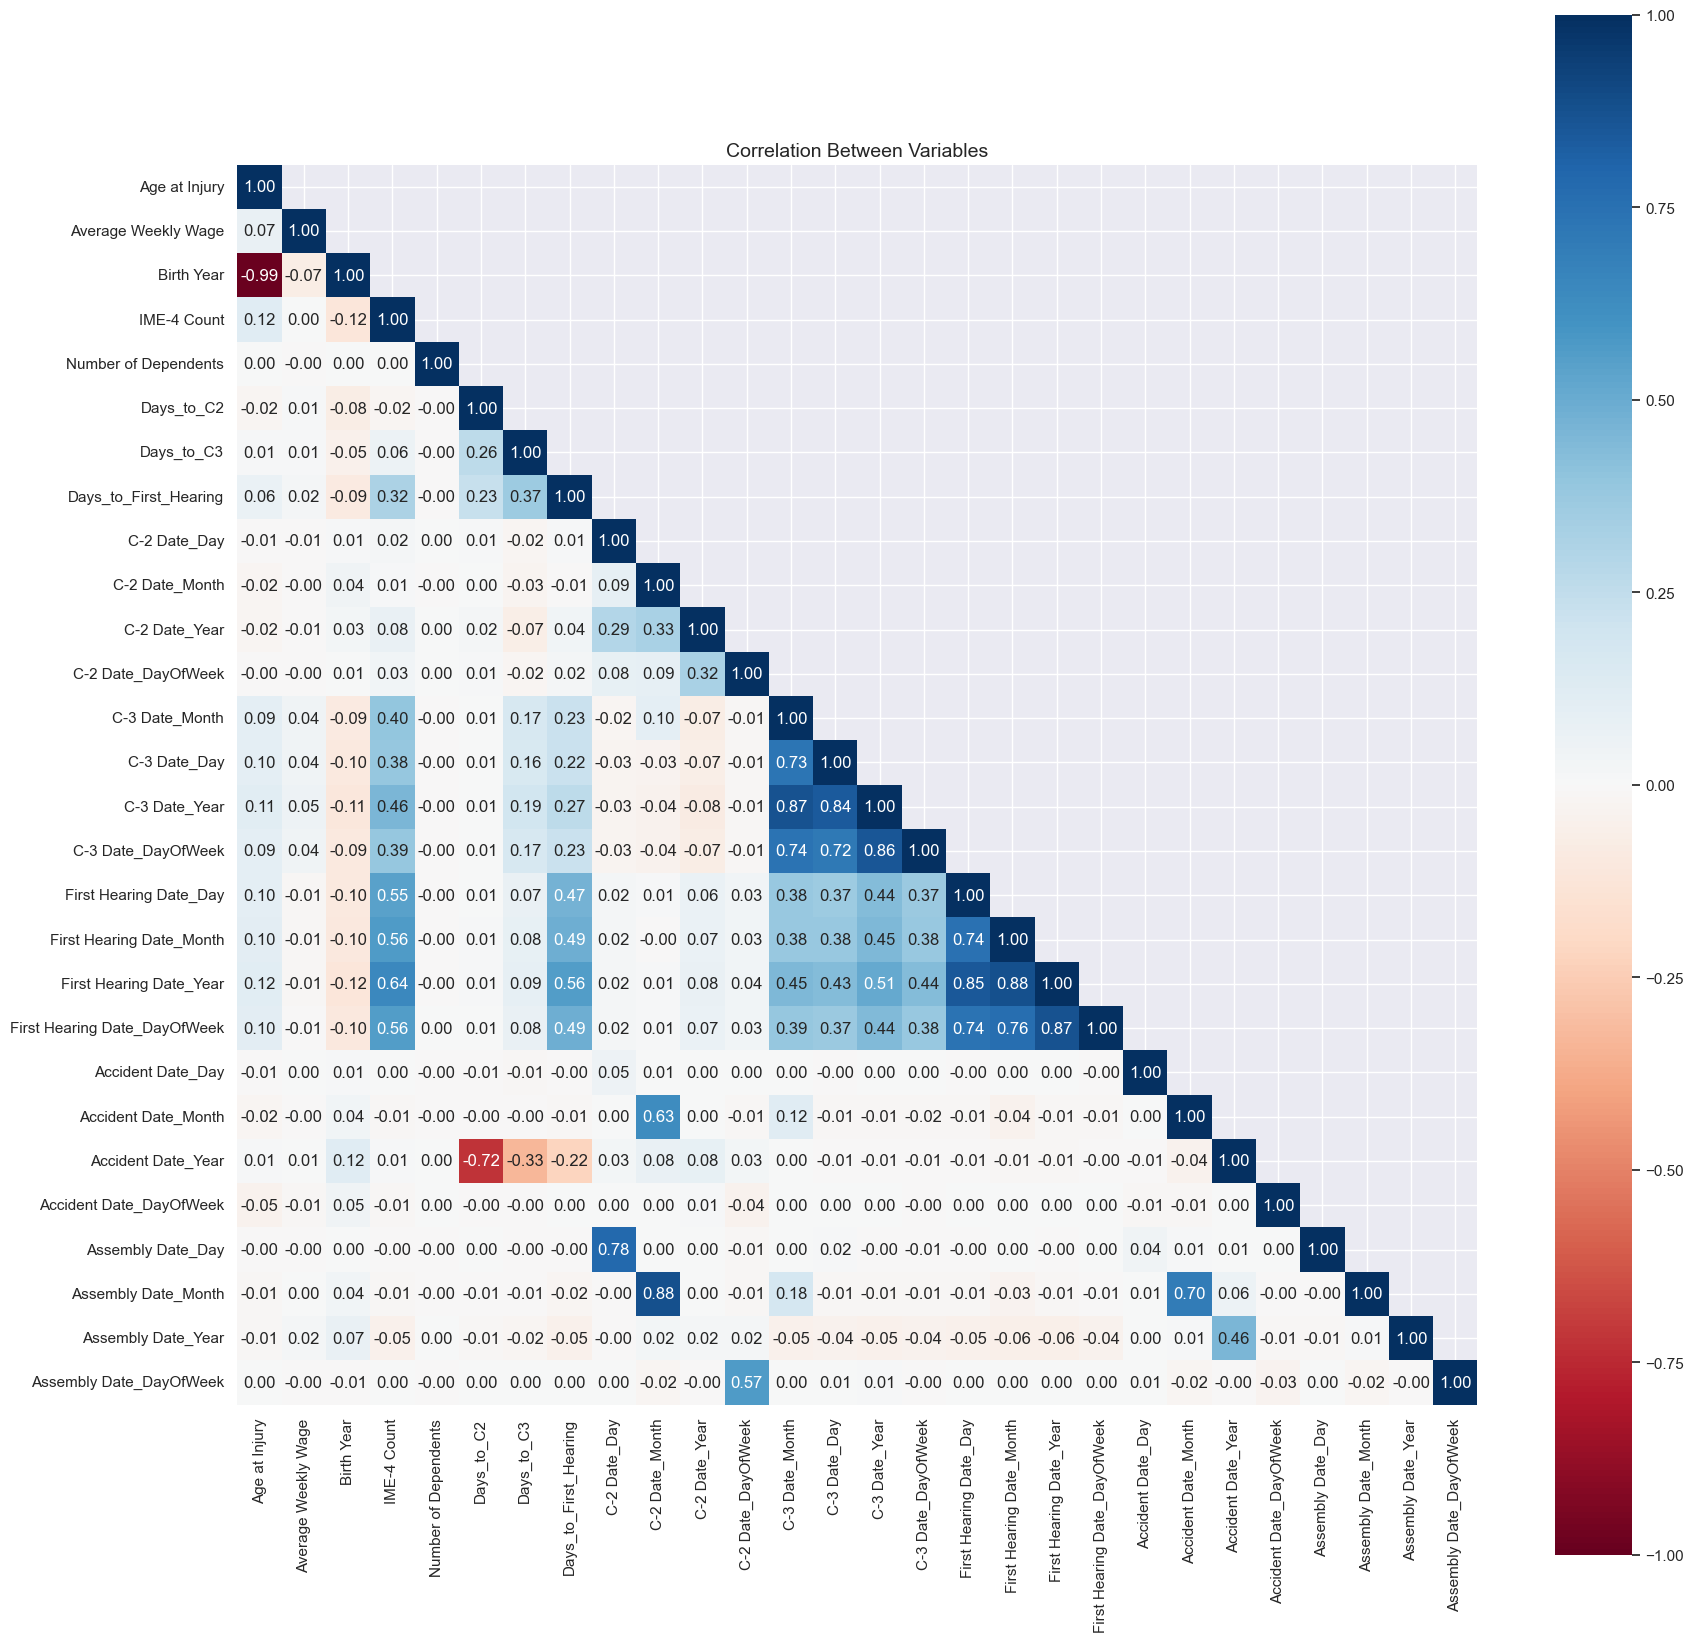

In [19]:
# initial correlation matrix with the respective values
corr_matrix = X_train[numerical_features].corr()

mask = np.tri(*corr_matrix.shape, k=0, dtype=bool)
# Keeps values where mask is True
corr_matrix = corr_matrix.where(mask)

# defines the figure size
fig, ax = plt.subplots(figsize=(20, 20))
# heatmap of the initial correlation matrix
l = sns.heatmap(corr_matrix, square=True, annot=True, fmt=".2f", vmax=1, vmin=-1, cmap='RdBu', ax=ax)
plt.title('Correlation Between Variables', size=14)
plt.show()

High correlation, abose |0.8|

1. Age at Injury and Birth Year → -0.99
2. C-3 Date_Year and C-3 Date_Day → 0.84
3. C-3 Date_Year and C-3 Date_Month → 0.87
4. C-3 Date_Year and C-3 Date_DayOfWeek → 0.86
5. First Hearing Date_Year and First Hearing Date_Day → 0.85
6. First Hearing Date_Year and First Hearing Date_DayOfWeek → 0.87
7. First Hearing Date_Year and  First Hearing Date_Month → 0.88
9. Assembly Date_Month and C-2 Date_Month → 0.88

Might drop Birth Year, C-3 Date_Year, First Hearing Date_Year and Assembly Date_Month


*XGBoosted Feature Importance*

In [ ]:
xgb = XGBClassifier(max_depth=5, n_estimators= 200).fit(X_train,y_train)

In [21]:
feature_importances_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [22]:
for _, row in feature_importances_xgb.iterrows():
    if row["Importance"] > 0.01:
        print(f"{row['Feature']} -> {row['Importance']}. Keep it")

Relative_Wage -> 0.32270821928977966. Keep it
Known C-2 Date -> 0.2650345265865326. Keep it
Attorney/Representative_Y -> 0.14141052961349487. Keep it
Average Weekly Wage -> 0.050985295325517654. Keep it
Alternative Dispute Resolution_Y -> 0.033108729869127274. Keep it
IME-4 Count -> 0.028561610728502274. Keep it
COVID-19 Indicator_Y -> 0.015492129139602184. Keep it
Known First Hearing Date -> 0.01455068588256836. Keep it
Carrier Type_UNKNOWN -> 0.011622859165072441. Keep it


*Light Gradient Boosted Feature Importance*

In [ ]:
lgb = LGBMClassifier(class_weight='balanced',verbose=-1).fit(X_train,y_train)

In [24]:
feature_importances_lgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [25]:
for _, row in feature_importances_lgb.iterrows():
    if row["Importance"] < 99:
        print(f"{row['Feature']} -> {row['Importance']}. Drop it")

Accident_Season_Cos -> 87. Drop it
Carrier Type_4A. SELF PRIVATE -> 87. Drop it
Medical Fee Region_UK -> 87. Drop it
Accident_Season_Sin -> 80. Drop it
Carrier Type_5D. SPECIAL FUND - UNKNOWN -> 74. Drop it
Carrier Type_UNKNOWN -> 70. Drop it
Medical Fee Region_IV -> 60. Drop it
Medical Fee Region_II -> 55. Drop it
Medical Fee Region_III -> 50. Drop it
Known First Hearing Date -> 45. Drop it
Alternative Dispute Resolution_Y -> 40. Drop it
Gender_Unknown -> 29. Drop it
Holiday_Accident -> 28. Drop it
Weekend_Accident -> 20. Drop it
Age_Group -> 17. Drop it
Known Age at Injury -> 16. Drop it
Known C-3 Date -> 8. Drop it
Known C-2 Date -> 6. Drop it
Alternative Dispute Resolution_U -> 0. Drop it
Known Assembly Date -> 0. Drop it
Known Accident Date -> 0. Drop it
Known Birth Year -> 0. Drop it
Financial Impact Category -> 0. Drop it


*Decision Tree feature importance*

In [26]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, class_weight='balanced').fit(X_train,y_train)

In [27]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [28]:
for _, row in feature_importance_df.iterrows():
    if row["Importance"] > 0.01:
        print(f"{row['Feature']} -> {row['Importance']}. Keep it")

IME-4 Count -> 0.26023708716340976. Keep it
Days_to_First_Hearing -> 0.156716503216635. Keep it
C-2 Date_Year -> 0.15544608865650675. Keep it
Enc WCIO Nature of Injury Code -> 0.1001360701977114. Keep it
Average Weekly Wage -> 0.06718828887501656. Keep it
C-3 Date_Day -> 0.05823441823660328. Keep it
Relative_Wage -> 0.05674212137151535. Keep it
Enc WCIO Part Of Body Code -> 0.043565632634459686. Keep it
Known First Hearing Date -> 0.029148161013213256. Keep it
Attorney/Representative_Y -> 0.020106233693184428. Keep it
Age at Injury -> 0.01730487782478061. Keep it
Accident Date_Day -> 0.013049091545675719. Keep it


*Lasso*

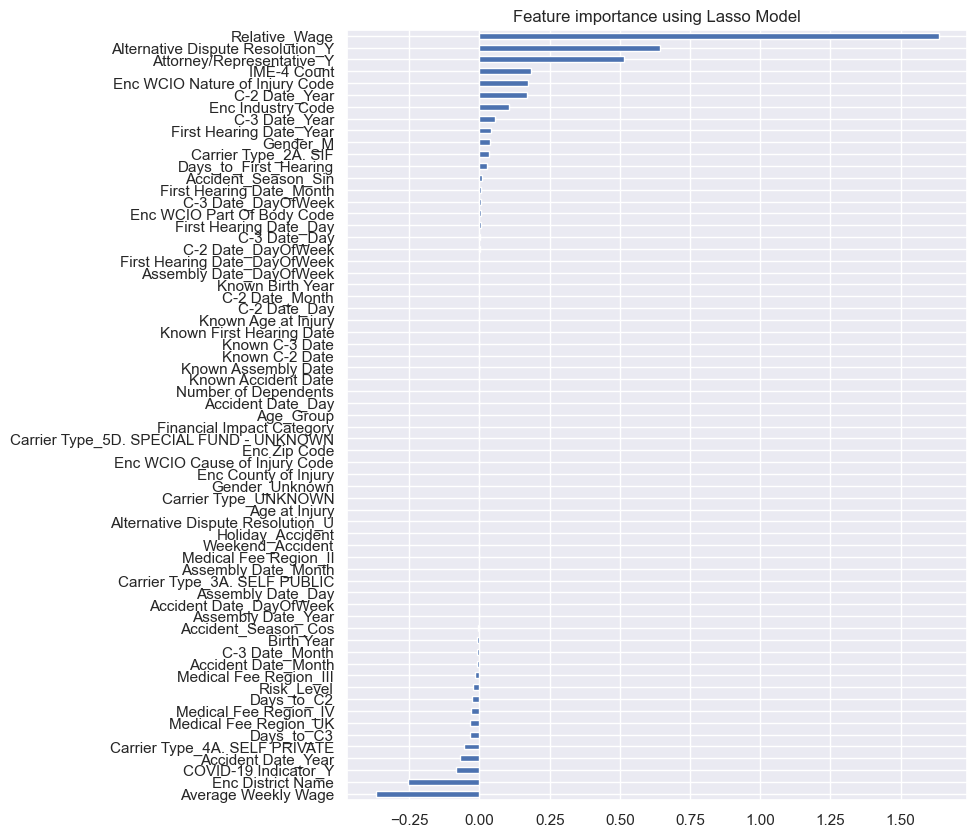

In [29]:
lasso = feature_selection_Lasso(X_train,y_train)

In [30]:
for i in range(len(lasso)):
    if abs(lasso[i]) > 0.01:
        print(f"{X_train.columns[i]} -> {lasso[i]}, Keep it")

Average Weekly Wage -> -0.37040434219401747, Keep it
IME-4 Count -> 0.1844659005853687, Keep it
Accident Date_Year -> -0.06789840683068823, Keep it
Accident Date_Month -> -0.010465395524552622, Keep it
C-2 Date_Year -> 0.16915722838413916, Keep it
C-3 Date_Year -> 0.05629348646726698, Keep it
First Hearing Date_Year -> 0.04221307732760047, Keep it
Days_to_First_Hearing -> 0.027047714947445588, Keep it
Days_to_C2 -> -0.026051973936208214, Keep it
Days_to_C3 -> -0.032660474448052354, Keep it
Risk_Level -> -0.02305381323376925, Keep it
Alternative Dispute Resolution_Y -> 0.6417791444835932, Keep it
Attorney/Representative_Y -> 0.5154447190882937, Keep it
Carrier Type_2A. SIF -> 0.03280268020760043, Keep it
Carrier Type_4A. SELF PRIVATE -> -0.0545247719074809, Keep it
COVID-19 Indicator_Y -> -0.0819276246291615, Keep it
Gender_M -> 0.038997185762740395, Keep it
Medical Fee Region_III -> -0.016208988793508843, Keep it
Medical Fee Region_IV -> -0.02852374077899637, Keep it
Medical Fee Region

*Chi-squared test*

In [31]:
for col in categorical_features:
    TestIndependence(X_train[col],y_train,col,alpha=0.05,verbose = False)

Alternative Dispute Resolution_U is NOT an important predictor. (Discard Alternative Dispute Resolution_U from model)
Known Accident Date is NOT an important predictor. (Discard Known Accident Date from model)
Known Assembly Date is NOT an important predictor. (Discard Known Assembly Date from model)
Holiday_Accident is NOT an important predictor. (Discard Holiday_Accident from model)
Financial Impact Category is NOT an important predictor. (Discard Financial Impact Category from model)


*Logistic Regression RFE*

In [32]:
LR = LogisticRegression()

In [33]:
best_LR = feature_selection_RFE(X_train,y_train,n_features,model=LR)

In [34]:
for col in numerical_features+categorical_features:
    if col not in best_LR:
        print(f"LR : Drop {col}")

LR : Drop Number of Dependents
LR : Drop C-2 Date_Month
LR : Drop Assembly Date_Day
LR : Drop Assembly Date_DayOfWeek
LR : Drop Alternative Dispute Resolution_U
LR : Drop Enc Zip Code
LR : Drop Holiday_Accident
LR : Drop Accident_Season_Cos


<hr>

### Numerical Features

| Predictor                        | Spearman | Feature Importance XGB  | Feature Importance LGB | Feature Importance DT | Lasso| RFE Logistic Regression | What to do? (One possible way to "solve") |
|----------------------------------|----------|----------|----------|-----------|-----------|-----------------------|---------------------------------------------|
| Age at Injury                    | Keep     | Drop     | Keep     | Keep      | Drop   | Keep      | Try with and without                        |
| Average Weekly Wage              | Keep     | Keep     | Keep     | Keep      | Keep   | Keep      | Include in the model                        |
| Birth Year                       | Drop     | Drop     | Keep     | Drop      | Drop   | Keep      | Discard                    |
| IME-4 Count                      | Keep     | Keep     | Keep     | Keep      | Keep   | Keep      | Include in the model                        |
| Number of Dependents             | Keep     | Drop     | Keep     | Drop      | Drop   | Drop      | Discard                         |
| Days_to_C2                       | Keep     | Drop     | Keep     | Drop      | Keep   | Keep      | Try with and without                        |
| Days_to_C3                       | Keep     | Drop     | Keep     | Drop      | Keep   | Keep      | Try with and without                        |
| Days_to_First_Hearing            | Keep     | Drop     | Keep     | Keep      | Keep   | Keep      | Include in the model                        |
| C-2 Date_Day                     | Keep     | Drop     | Keep     | Keep      | Drop   | Keep      | Try with and without                        |
| C-2 Date_Month                   | Keep     | Drop     | Keep     | Drop      | Drop   | Drop      | Discard                                     |
| C-2 Date_Year                    | Keep     | Drop     | Keep     | Keep      | Keep   | Keep      | Include in the model                        |
| C-2 Date_DayOfWeek               | Keep     | Drop     | Keep     | Drop      | Drop   | Keep      | Try with and without                        |
| C-3 Date_Day                     | Keep     | Drop     | Keep     | Keep      | Drop   | Keep      | Try with and without                        |
| C-3 Date_Month                   | Keep     | Drop     | Keep     | Drop      | Drop   | Keep      | Try with and without                        |
| C-3 Date_Year                    | Drop     | Drop     | Keep     | Drop      | Keep   | Keep      | Try with and without                        |
| First Hearing Date_Day           | Keep     | Drop     | Keep     | Drop      | Drop   | Keep      | Try with and without                        |
| First Hearing Date_Month         | Keep     | Drop     | Keep     | Drop      | Drop   | Keep      | Try with and without                        |
| First Hearing Date_Year          | Drop     | Drop     | Keep     | Drop      | Keep   | Keep      | Try with and without                        |
| First Hearing Date_DayOfWeek     | Keep     | Drop     | Keep     | Drop      | Drop   | Keep      | Try with and without                        |
| Accident Date_Day                | Keep     | Drop     | Keep     | Keep      | Drop   | Keep      | Discard                                     |
| Accident Date_Month              | Keep     | Drop     | Keep     | Drop      | Keep   | Keep      | Try with and without                         |
| Accident Date_Year               | Keep     | Drop     | Keep     | Drop      | Keep   | Keep      | Include in the model                        |
| Assembly Date_Day                | Keep     | Drop     | Keep     | Drop      | Drop   | Drop      | Discard                                     |
| Assembly Date_Month              | Drop     | Drop     | Keep     | Drop      | Drop   | Keep      | Discard                                     |
| Assembly Date_Year               | Keep     | Drop     | Keep     | Drop      | Drop   | Keep      | Include in the model                        |
| Assembly Date_DayOfWeek          | Keep     | Drop     | Keep     | Drop      | Drop   | Drop      | Discard                                     |

<hr>

### Categorical Features

| Predictor                        | Mutual Info Classif | Feature Importance XGB | Feature Importance LGB | Feature Importance DT | Lasso | RFE Logistic Regression | Chi-Squared Test | What to do? (One possible way to "solve") |
|----------------------------------|----------|------------|------------|------------|------------|------------|------------|------------|
| Alternative Dispute Resolution_U | Drop     | Drop       | Drop       | Drop       | Drop       | Drop       | Drop       | Discard       |
| Alternative Dispute Resolution_Y | Drop     | Keep       | Drop       | Drop       | Keep       | Keep       | Keep       | Try with and without       |
| Attorney/Representative_Y        | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Include in the model       |
| Carrier Type_2A. SIF             | Keep     | Drop       | Keep       | Drop       | Keep       | Keep       | Keep       | Try with and without       |
| Carrier Type_3A. SELF PUBLIC     | Keep     | Drop       | Keep       | Drop       | Drop       | Keep       | Keep       | Try with and without       |
| Carrier Type_4A. SELF PRIVATE    | Drop     | Drop       | Keep       | Drop       | Keep       | Keep       | Keep       | Try with and without       |
| Carrier Type_5D. SPECIAL FUND - UNKNOWN| Drop | Drop     | Drop       | Drop       | Drop       | Keep       | Keep       | Discard       |
| Carrier Type_UNKNOWN             | Drop     | Keep       | Drop       | Drop       | Drop       | Keep       | Keep       | Discard       |
| COVID-19 Indicator_Y             | Drop     | Keep       | Keep       | Drop       | Keep       | Keep       | Keep       | Try with and without       |
| Enc County of Injury             | Keep     | Drop       | Keep       | Drop       | Drop       | Keep       | Keep       | Try with and without       |
| Enc District Name                | Keep     | Drop       | Keep       | Drop       | Keep       | Keep       | Keep       | Try with and without       |
| Enc Industry Code                | Keep     | Drop       | Keep       | Drop       | Keep       | Keep       | Keep       | Try with and without       |
| Enc WCIO Cause of Injury Code    | Keep     | Drop       | Keep       | Drop       | Drop       | Keep       | Keep       | Try with and without       |
| Enc WCIO Nature of Injury Code   | Keep     | Drop       | Keep       | Keep       | Keep       | Keep       | Keep       | Include in the model       |
| Enc WCIO Part Of Body Code       | Keep     | Drop       | Keep       | Keep       | Drop       | Keep       | Keep       | Try with and without       |
| Enc Zip Code                     | Drop     | Drop       | Keep       | Drop       | Drop       | Drop       | Keep       | Discard       |
| Financial Impact Category        | Keep     | Drop       | Drop       | Drop       | Drop       | Keep       | Drop       | Discard       |
| Gender_M                         | Keep     | Drop       | Keep       | Drop       | Keep       | Keep       | Keep       | Try with and without       |
| Gender_Unknown                   | Drop     | Drop       | Drop       | Drop       | Drop       | Keep       | Keep       | Discard       |
| Holiday_Accident                 | Drop     | Drop       | Drop       | Drop       | Drop       | Drop       | Drop       | Discard       |
| Known Accident Date              | Keep     | Drop       | Drop       | Drop       | Drop       | Keep       | Drop       | Discard       |
| Known Assembly Date              | Keep     | Drop       | Drop       | Drop       | Drop       | Keep       | Drop       | Discard       |
| Known C-2 Date                   | Keep     | Keep       | Drop       | Drop       | Drop       | Keep       | Keep       | Try with and without       |
| Known C-3 Date                   | Keep     | Drop       | Drop       | Drop       | Drop       | Keep       | Keep       | Discard       |
| Known First Hearing Date         | Keep     | Keep       | Drop       | Keep       | Drop       | Keep       | Keep       | Try with and without       |
| Known Age at Injury              | Keep     | Drop       | Drop       | Drop       | Drop       | Keep       | Keep       | Discard       |
| Known Birth Year                 | Keep     | Drop       | Drop       | Drop       | Drop       | Keep       | Drop       | Discard       |
| Medical Fee Region_II            | Drop     | Drop       | Drop       | Drop       | Drop       | Keep       | Drop       | Discard       |
| Medical Fee Region_III           | Drop     | Drop       | Drop       | Drop       | Keep       | Keep       | Drop       | Discard       |
| Medical Fee Region_IV            | Keep     | Drop       | Drop       | Drop       | Keep       | Keep       | Drop       | Discard       |
| Medical Fee Region_UK            | Drop     | Drop       | Drop       | Drop       | Keep       | Keep       | Drop       | Discard       |
| Relative_Wage                    | Keep     | Keep       | Keep       | Keep       | Keep       | Keep       | Keep       | Include in the model       |
| Risk_Level                       | Keep     | Drop       | Keep       | Drop       | Drop       | Keep       | Keep       | Try with and without       |
| Weekend_Accident                 | Drop     | Drop       | Drop       | Drop       | Drop       | Keep       | Keep       | Discard       |
| Age_Group                        | Keep     | Drop       | Drop       | Drop       | Drop       | Keep       | Keep       | Discard       |
| Accident_Season_Sin              | Drop     | Drop       | Keep       | Drop       | Drop       | Keep       | Keep       | Discard       |
| Accident_Season_Cos              | Drop     | Drop       | Drop       | Drop       | Drop       | Drop       | Keep       | Discard       |

<hr>

#### Feature Selection Guidelines:
- Numerical Features

    - Score Range 0–2: Drop the feature.
    - Score Range 3–4: Experiment by including and excluding the feature to evaluate its impact.
    - Score Range 5–6: Retain the feature.

- Categorical Features

    - Score Range 0–3: Drop the feature.
    - Score Range 4–5: Experiment by including and excluding the feature to evaluate its impact.
    - Score Range 6–7: Retain the feature.